In [1]:
from __future__ import print_function
from keras import regularizers
import keras
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import random
import time
import math
import pandas
import numpy
import matplotlib.pyplot as plt
import os
import sys
import configparser
import matplotlib
import csv
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from pandas.tools.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import linear_model
import traceback
import glob
import datetime
import time
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn import preprocessing
from pprint import pprint
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


In [2]:
def load_cfg(conf_file):
    config = configparser.RawConfigParser()
    config.read(conf_file)
    return config

def load_header(csv_file, print_out = False):
    
    # Loading headers
    
    headers = pd.read_csv(csv_file,header=None, nrows=1).values[0]
    idx_to_key = {}
    key_to_idx = {}
    
    for i in range(0, len(headers)):
        idx = i
        key = headers[i]
        key_to_idx[key] = idx
        idx_to_key[idx] = key
    
    if print_out is True:
        print(idx_to_key)
        
    return headers, idx_to_key, key_to_idx

In [3]:
# Loading config files

config_file = 'config/creep_more_features.properties'
config = load_cfg(config_file)
csv_file = config.get("FILES", 'input_file')
cols_to_remove = config.get("COLUMNS",'ignore_cols').split(",")
target_col = config.get("COLUMNS",'col_to_predict')
scaler_option = config.get("ML",'scaler')

print(csv_file,cols_to_remove,target_col)

data/creep_more_features.csv ['id', 'NAME', 'RuptureTime'] LMP


In [4]:
def data_load_shuffle(csv_file, cols_to_remove, target_col, random_state=0):
    print ("* Data loading from", csv_file)
    data = pandas.read_csv(csv_file)
    data_df = data[data[target_col].notnull()]
    for col in cols_to_remove:
        del data_df[col]
    data_df_shuffle = data_df.sample(frac=1, random_state=random_state)
    
    y_train = pd.DataFrame(data_df_shuffle[target_col])
    
    # training set is without target column
    del data_df_shuffle[target_col]
    x_train = data_df_shuffle.copy()
    
    headers, idx_to_key, key_to_idx = load_header(csv_file)
        
    cols_to_remove_ = []
    headers = list(headers)
    header_y = target_col
    
    for col in cols_to_remove:
        headers.remove(col)
    
    headers.remove(target_col)
    
    # dataframe to numpy array
    y_train = y_train.values
    x_train = x_train.values
    
    # reshaping target values
    y_train = y_train.reshape(y_train.shape[0],1)
    
    # set data types
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    header_x = np.array(headers)
    
    print("* input columns = ", header_x)
    print("* target column = ", header_y)
    
    return data_df, x_train, y_train, header_x, header_y

In [5]:
data_df, x_train, y_train, header_x, header_y = data_load_shuffle(csv_file, cols_to_remove, target_col)

* Data loading from data/creep_more_features.csv
* input columns =  ['gs' 'dFCC' 'dFECR_B2' 'dL12' 'dLAVES_C14' 'dM23C6' 'dM2B_CB' 'dM3B2_D5A'
 'dNbC' 'dNIAL_B2' 'dSIGMA' 'dT' 'Stress' 'T1' 'T1_DGM_NbC'
 'T1_FCC_ACR_AL' 'T1_FCC_ACR_CR' 'T1_FCC_ACR_CU' 'T1_FCC_ACR_FE'
 'T1_FCC_ACR_MN' 'T1_FCC_ACR_MO' 'T1_FCC_ACR_NB' 'T1_FCC_ACR_NI'
 'T1_FCC_ACR_SI' 'T1_FCC_ACR_TI' 'T1_FCC_ACR_V' 'T1_FCC_ACR_W'
 'T1_FCC_ACR_Y' 'T1_FCC_ACR_ZR' 'T1_FCC_CX_AL' 'T1_FCC_CX_B' 'T1_FCC_CX_C'
 'T1_FCC_CX_CR' 'T1_FCC_CX_CU' 'T1_FCC_CX_FE' 'T1_FCC_CX_MN'
 'T1_FCC_CX_MO' 'T1_FCC_CX_NB' 'T1_FCC_CX_NI' 'T1_FCC_CX_SI'
 'T1_FCC_CX_TI' 'T1_FCC_CX_V' 'T1_FCC_CX_W' 'T1_FCC_CX_Y' 'T1_FCC_CX_ZR'
 'T1_FCC_X_AL' 'T1_FCC_X_B' 'T1_FCC_X_C' 'T1_FCC_X_CR' 'T1_FCC_X_CU'
 'T1_FCC_X_FE' 'T1_FCC_X_MN' 'T1_FCC_X_MO' 'T1_FCC_X_NB' 'T1_FCC_X_NI'
 'T1_FCC_X_SI' 'T1_FCC_X_TI' 'T1_FCC_X_V' 'T1_FCC_X_W' 'T1_FCC_X_Y'
 'T1_FCC_X_ZR' 'T1_L12_X_AL' 'T1_L12_X_B' 'T1_L12_X_C' 'T1_L12_X_CR'
 'T1_L12_X_CU' 'T1_L12_X_FE' 'T1_L12_X_MN' 'T1_L12_X_MO' 

In [6]:
def get_new_x_ys(x_train, idx_of_stress):
    # experimental code
    x_train_enriched = []

    y_1 = []
    y_2 = []
    
    for i in range(0,len(x_train)):

        x = x_train[i]
        y = y_train[i][0]
        Stress = x[idx_of_stress]

        new_x = list(x)
        if(Stress) ==70:
            new_x.append(24563.25)
            new_x.append(24126)
        elif(Stress) ==100:
            new_x.append(23592)
            new_x.append(23174)
        elif(Stress) ==130:
            new_x.append(22812.5)
            new_x.append(22553)
        elif(Stress) ==170:
            new_x.append(22198)
            new_x.append(22050.5)
        elif(Stress) ==200:
            new_x.append(21612.5)
            new_x.append(21276)
        elif(Stress) ==250:
            new_x.append(20899.25)
            new_x.append(20562)
        elif(Stress) ==300:
            new_x.append(20317.75)
            new_x.append(19825.5)
        else:
            print("Error!")

        if(new_x[-1]<y):
            y_1.append([1])
        else:
            y_1.append([0])

        if(new_x[-2]<y):
            y_2.append([1])
        else:
            y_2.append([0])

        x_train_enriched.append(new_x)

    x_train_enriched = np.array(x_train_enriched)
    x_train = x_train_enriched
    y_1 = np.array(y_1)
    y_2 = np.array(y_2)
    return x_train, y_1, y_2

x_train, y_1, y_2 = get_new_x_ys(x_train, idx_of_stress=12)

In [7]:
def corr_analysis(data_df, target_col, csv_file, path_to_mine_jar, output_dir, top_k=10, show_charts=False):
    
    # Calculating MIC using the external JAR file
    print("* Calculating MIC ..")
    f = open(csv_file, 'r')
    header = f.readline().split(",")
    for i in range(0, len(header)):
        if(header[i]==target_col):
            break
    primary_index = i
    cmd_to_execute = "nohup java -jar "+path_to_mine_jar+" "+csv_file+" "+str(primary_index)+" >MINE.log 2>&1&"
    print("* Executing the following command:", cmd_to_execute)
    os.system(cmd_to_execute)
    
    # Computing Correlation Coefficients
    
    correlation = data_df.corr()[target_col]
    if(len(correlation)<top_k):
        top_k=len(correlation)
    correlation = correlation.sort_values(ascending = False).dropna()
    
    # removing target column
    del correlation[target_col]
    ax = correlation.plot(kind='bar',alpha=0.8)
    ax.set_ylabel("PCC(x,"+target_col+")", fontsize=12)
    plt.axhline(0, color='k')
    
    if(show_charts==True):
        plt.show()
        
    plt.savefig(output_dir+"/"+'corr_analysis.png')
    
    plt.clf()
    correlation_rank = correlation.apply(lambda x: numpy.sqrt(x* x))
    ax = correlation_rank.sort_values(ascending=False)[:top_k].plot(kind='bar', alpha=0.5)
    ax.set_ylabel("$\sqrt{{PCC(x,"+target_col+")}^2}$", fontsize=12)
    plt.axhline(0, color='k')
    plt.savefig(output_dir+'/'+'corr_analysis_sqrt.png')
        
    if(show_charts==True):
        plt.show()
    
    print(correlation_rank[:top_k])
    print('\n')

    plt.close()
    print(" - Pearson Correlation Coefficient [",output_dir+"/"+'corr_analysis.png'+" ]")
    print(" - Pearson Correlation Coefficient (SQRT) [",output_dir+"/"+'corr_analysis.png'+" ]")

* Calculating MIC ..
* Executing the following command: nohup java -jar lib/MINE.jar data/creep_more_features.csv 498 >MINE.log 2>&1&


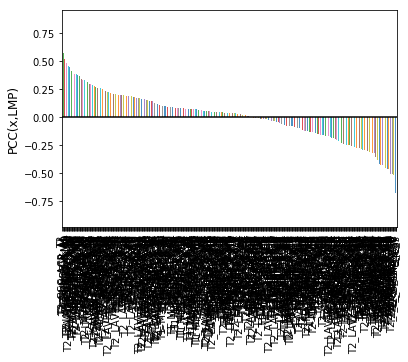

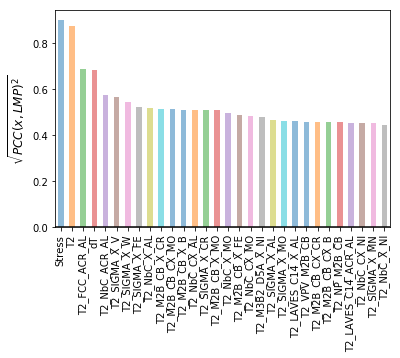

T2                     0.871040
T2_FCC_ACR_AL          0.687347
T2_NbC_ACR_AL          0.571532
T2_NbC_X_AL            0.514863
T2_NbC_CX_AL           0.508335
T2_NbC_X_MO            0.494346
T2_NbC_CX_MO           0.481916
T2_M3B2_D5A_X_NI       0.477323
T2_LAVES_C14_X_AL      0.461318
T2_LAVES_C14_ACR_AL    0.453716
T2_NbC_CX_NI           0.450286
T2_NbC_X_NI            0.442026
T2_M3B2_D5A_X_W        0.416499
T2_FCC_CX_W            0.413643
T2_M3B2_D5A_CX_W       0.408337
T2_FCC_X_W             0.396573
T2_M3B2_D5A_X_MO       0.389424
T2_M3B2_D5A_X_B        0.388564
T2_M3B2_D5A_X_FE       0.388010
T2_FCC_CX_MO           0.383383
dFCC                   0.381614
T2_M3B2_D5A_X_CR       0.372769
T2_FCC_CX_NB           0.367729
T2_FCC_X_MO            0.365833
T2_FCC_X_NB            0.363266
T2_FCC_ACR_W           0.342185
T2_NbC_X_W             0.342043
T2_NbC_ACR_W           0.338603
T2_FCC_CX_NI           0.333442
T2_FCC_CX_CR           0.333209
Name: LMP, dtype: float64


 - Pearson C

In [8]:
path_to_mine_jar = config.get("FILES", 'path_to_mine_jar')
output_dir = config.get("FILES", 'output_dir')

corr_analysis(data_df, target_col, csv_file, path_to_mine_jar, output_dir, show_charts=True, top_k=30)

In [9]:
num_of_features = config.get("EXPERIMENT","num_of_features")

if(num_of_features=="MAX"):
    num_of_features = len(data_df.columns) - 1
else:
    num_of_features = int(num_of_features)
    
num_of_folds = int(config.get("EXPERIMENT","num_of_folds"))
num_of_sets = config.get("EXPERIMENT","num_of_sets")


In [10]:
def load_model_parameters(config):

    model_parameters = {}
    for key in config['ML']:  
        model_parameters[key] = config.get("ML",key)
    return model_parameters

def define_model(model_type, num_of_features, model_parameters):

    if model_type == "LR":
        model = Pipeline([
          ('feature_selection', SelectKBest(f_regression, k=num_of_features)),
          ('classification', LinearRegression())
        ])
    elif model_type == "RF":
        if model_parameters['rf_max_depth'] is not None:
            rf_max_depth = int(model_parameters['rf_max_depth'])
        else:
            rf_max_depth = None
        model = Pipeline([
          ('feature_selection', SelectKBest(f_regression, k=num_of_features)),
          ('classification', RandomForestRegressor(n_estimators = int(model_parameters['rf_n_estimators']), 
                                                   max_features = model_parameters['rf_max_features'], 
                                                   max_depth = rf_max_depth, 
                                                   min_samples_split = int(model_parameters['rf_min_samples_split']), 
                                                   min_samples_leaf = int(model_parameters['rf_min_samples_leaf']), 
                                                   bootstrap = bool(model_parameters['rf_bootstrap']), 
                                                  ))])
    elif model_type == "NN":
        model = Pipeline([
          ('feature_selection', SelectKBest(f_regression, k=num_of_features)),
          ('classification', KNeighborsRegressor(n_neighbors = int(model_parameters['nn_n_neighbors']),
                                                 weights = model_parameters['nn_weights'],
                                                 algorithm = model_parameters['nn_algorithm'],
                                                 leaf_size = int(model_parameters['nn_leaf_size']),
                                                 p = int(model_parameters['nn_p'])))
        ])
    elif model_type == "KR":
        model = Pipeline([
          ('feature_selection', SelectKBest(f_regression, k=num_of_features)),
          ('classification', KernelRidge(alpha = float(model_parameters['kr_alpha']),
                                         kernel = model_parameters['kr_kernel'],
                                         gamma = model_parameters['kr_gamma'],
                                         degree = int(model_parameters['kr_degree']),
                                         coef0 = float(model_parameters['kr_coef0'])))
        ])
    elif model_type == "BR":
        model = Pipeline([
          ('feature_selection', SelectKBest(f_regression, k=num_of_features)),
          ('classification', linear_model.BayesianRidge(n_iter = int(model_parameters['br_n_iter']),
                                                        alpha_1 = float(model_parameters['br_alpha_1']),
                                                        alpha_2 = float(model_parameters['br_alpha_2']),
                                                        tol = float(model_parameters['br_tol']),
                                                        lambda_1 = float(model_parameters['br_lambda_1']),
                                                        lambda_2 = float(model_parameters['br_lambda_2']),
                                                        compute_score = bool(model_parameters['br_compute_score']),
                                                        fit_intercept = bool(model_parameters['br_fit_intercept'])))
        ])
    elif model_type == "SVM":
        model = Pipeline([
          ('feature_selection', SelectKBest(f_regression, k=num_of_features)),
          ('classification', svm.SVR(kernel = model_parameters['svm_kernel'],
                                     degree = int(model_parameters['svm_degree']),
                                     coef0 = float(model_parameters['svm_coef0']),
                                     tol = float(model_parameters['svm_tol']),
                                     C = float(model_parameters['svm_c']),
                                     gamma = model_parameters['svm_gamma'],
                                     epsilon = float(model_parameters['svm_epsilon']),
                                     shrinking = bool(model_parameters['svm_shrinking'])))
        ])
        
    return model

def rescale_x(scaler_option, x_train):
    scale = None
    if scaler_option=='None':
        x_train_ = x_train
    elif scaler_option == "MinMaxScaler":
        scale = preprocessing.MinMaxScaler()
        x_train_ = scale.fit_transform(x_train)
    elif scaler_option == "MaxAbsScaler":
        scale = preprocessing.MaxAbsScaler()
        x_train_ = scale.fit_transform(x_train)
    elif scaler_option == "RobustScaler":
        scale = preprocessing.RobustScaler()
        x_train_ = scale.fit_transform(x_train)
    elif scaler_option == "QuantileTransformer":
        scale = preprocessing.QuantileTransformer()
        x_train_ = scale.fit_transform(x_train)
    elif scaler_option == "Normalizer":
        scale = preprocessing.Normalizer()
        x_train_ = scale.fit_transform(x_train)
    else:
        scale = preprocessing.StandardScaler()
        x_train_ = scale.fit_transform(x_train)
    return x_train_, scale
        
def train_and_predict(model, x_train, y_train, scaler_option, num_of_folds=5):
    
    x_train_, scale = rescale_x(scaler_option, x_train)
    y_train_ = y_train.reshape(y_train.shape[0],)
    predictions = cross_val_predict(model, x_train_, y_train_, cv=num_of_folds)
    actual_values = y_train_
    
    return predictions, actual_values

def train_and_save(model, tag, model_abbr, input_cols, target_col, RMSE, R2, x_train, y_train, scaler_option, path_to_save = '.'):
    
    x_train_, scale = rescale_x(scaler_option, x_train)
    y_train_ = y_train.reshape(y_train.shape[0],)
    
    print('* Training initiated ..')
    model.fit(x_train_, y_train_)
    print('* Training done.')
    actual_values = y_train_
    
    model_dict = {}
    model_dict['tag'] = tag
    model_dict['model'] = model
    model_dict['model_abbr'] = model_abbr
    model_dict['input_cols'] = input_cols
    model_dict['target_col'] = target_col
    model_dict['RMSE'] = RMSE
    model_dict['R2'] = R2
    model_dict['fitted_scaler_x'] = scale
    output_file = path_to_save+'/'+tag+'.pkl'
    print(model_dict)
    
    print("* Trained model saved to file:", output_file)
    
    output = open(output_file, 'wb')
    pickle.dump(model_dict, output)
    
def evaluate(predictions, actual_values):

    RMSE = numpy.sqrt(mean_squared_error(predictions,actual_values))
    R2 = r2_score(actual_values, predictions, multioutput='variance_weighted')
    
    return RMSE, R2
   
def show_comparison_chart(predictions, actual_values):
    plt.close()
    min_val = min(predictions)
    max_val = max(actual_values)

    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.ylim([min_val, max_val])
    plt.xlim([min_val, max_val])
    plt.grid(True)

    plt.scatter(predictions,actual_values)
    t = np.arange(min_val, max_val, 0.01)
    line, = plt.plot(t, t, lw=1)
    plt.show()

* (LR)	 RMSE = 21301467818147.902, R2 = -480897846457659293696.000
chart can't be generated
* (RF)	 RMSE =  436.552, R2 =    0.798


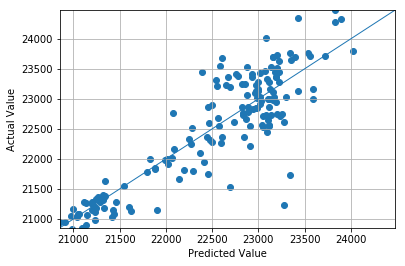

* (NN)	 RMSE =  624.493, R2 =    0.587


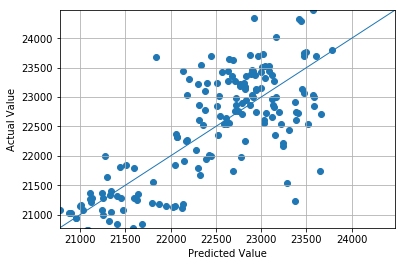

* (KR)	 RMSE =  488.010, R2 =    0.748


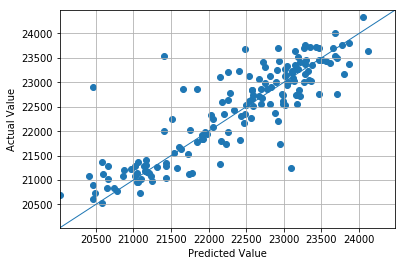

* (BR)	 RMSE =  368.162, R2 =    0.856


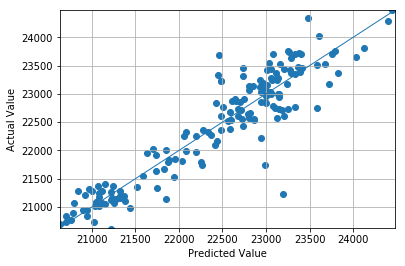

* (SVM)	 RMSE =  496.629, R2 =    0.739


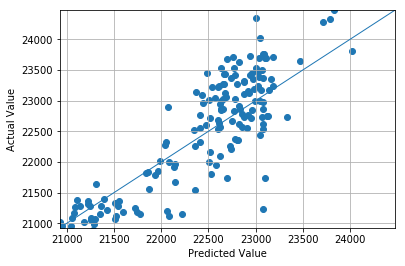

In [11]:
model_parameters = load_model_parameters(config)

    # Evaluations

for model_type in ["LR","RF","NN","KR","BR","SVM"]:
    
    model = define_model(model_type, num_of_features, model_parameters)
    model_parameters = load_model_parameters(config)
    predictions, actual_values = train_and_predict(model, x_train, y_train, scaler_option, num_of_folds=num_of_folds)
    RMSE, R2 = evaluate(predictions, actual_values)
    print("* (%s)\t RMSE = %8.3f, R2 = %8.3f"%(model_type, RMSE,R2))
    try:
        show_comparison_chart(predictions, actual_values)
    except:
        print("chart can't be generated")

In [12]:
    # Train and Save

input_cols = header_x
model = define_model('KR', num_of_features, model_parameters)
predictions, actual_values = train_and_predict(model, x_train, y_train, 'scaler_option', num_of_folds=num_of_folds)
RMSE, R2 = evaluate(predictions, actual_values)
print("* (%s)\t RMSE = %8.3f, R2 = %8.3f"%(model_type, RMSE,R2))

model = define_model('KR', num_of_features, model_parameters) # initialize model
train_and_save(model, 'NN-model-test-tag', 'NN', input_cols, target_col, RMSE, R2, x_train, y_train, scaler_option, path_to_save = '.')

* (SVM)	 RMSE = 201221.889, R2 = -42911.539
* Training initiated ..
* Training done.
{'tag': 'NN-model-test-tag', 'model': Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k=496, score_func=<function f_regression at 0x1a2ad5ab70>)), ('classification', KernelRidge(alpha=1.0, coef0=2.0, degree=3, gamma='sigmoid', kernel='linear',
      kernel_params=None))]), 'model_abbr': 'NN', 'input_cols': array(['gs', 'dFCC', 'dFECR_B2', 'dL12', 'dLAVES_C14', 'dM23C6',
       'dM2B_CB', 'dM3B2_D5A', 'dNbC', 'dNIAL_B2', 'dSIGMA', 'dT',
       'Stress', 'T1', 'T1_DGM_NbC', 'T1_FCC_ACR_AL', 'T1_FCC_ACR_CR',
       'T1_FCC_ACR_CU', 'T1_FCC_ACR_FE', 'T1_FCC_ACR_MN', 'T1_FCC_ACR_MO',
       'T1_FCC_ACR_NB', 'T1_FCC_ACR_NI', 'T1_FCC_ACR_SI', 'T1_FCC_ACR_TI',
       'T1_FCC_ACR_V', 'T1_FCC_ACR_W', 'T1_FCC_ACR_Y', 'T1_FCC_ACR_ZR',
       'T1_FCC_CX_AL', 'T1_FCC_CX_B', 'T1_FCC_CX_C', 'T1_FCC_CX_CR',
       'T1_FCC_CX_CU', 'T1_FCC_CX_FE', 'T1_FCC_CX_MN', 'T1_FCC_CX_MO',
       'T1_FCC_CX_NB',

In [ ]:
# Hyperparameter Tuning

def add_key_to_params(tag, params):
    tag = tag.lower()
    parameters = {}
    for key in params.keys():
        parameters[(tag+'_'+key).lower()] = params[key]
    return parameters

def hyperparameter_tuning(tag, x_train, y_train, num_of_folds, n_iter=100, random_state=0, verbose=1):
    
    rf_n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
    rf_max_features = ['auto', 'sqrt','log2']
    rf_max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
    rf_max_depth.append(None)
    rf_min_samples_split = [2, 5, 10]
    rf_min_samples_leaf = [1, 2, 4]
    rf_bootstrap = [True, False]

    rf_random_grid = {'n_estimators': rf_n_estimators,
                            'max_features': rf_max_features,
                            'max_depth': rf_max_depth,
                            'min_samples_split': rf_min_samples_split,
                            'min_samples_leaf': rf_min_samples_leaf,
                            'bootstrap': rf_bootstrap}

    nn_n_neighbors = [int(x) for x in np.linspace(start = 2, stop = 15, num = 5)]
    nn_weights = ['uniform', 'distance']
    nn_algorithm = ['auto','ball_tree','kd_tree','brute']
    nn_leaf_size = [int(x) for x in np.linspace(10, 100, num = 5)]
    nn_p = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]

    nn_random_grid = {'n_neighbors': nn_n_neighbors,
                'weights': nn_weights,
                'algorithm': nn_algorithm,
                'leaf_size': nn_leaf_size,
                'p': nn_p}

    kr_alpha = [float(x) for x in np.linspace(start = 0, stop = 50, num = 20)]
    kr_gamma = [None, 'RBF', 'laplacian','polynomial','chi2','exponential','sigmoid']
    kr_degree = [1,2,3]
    kr_coef0 = [0,1,2,3]
    kr_kernel =  ['linear']
        
    kr_random_grid = {'alpha': kr_alpha,
                      'kernel': kr_kernel,
                'gamma': kr_gamma,
                'degree': kr_degree,
                'coef0': kr_coef0}

    br_n_iter = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    br_alpha_1 = [float(x) for x in np.linspace(start = 1.e-5, stop = 1.e-7, num = 10)]
    br_alpha_2 = [float(x) for x in np.linspace(start = 1.e-5, stop = 1.e-7, num = 10)]
    br_tol = [float(x) for x in np.linspace(start = 1.e-2, stop = 1.e-4, num = 10)]
    br_lambda_1 = [float(x) for x in np.linspace(start = 1.e-5, stop = 1.e-7, num = 10)]
    br_lambda_2 = [float(x) for x in np.linspace(start = 1.e-5, stop = 1.e-7, num = 10)]
    br_compute_score = [True, False]
    br_fit_intercept = [True, False]
    br_random_grid = {'n_iter': br_n_iter,
                'alpha_1': br_alpha_1,
                'alpha_2': br_alpha_2,
                'tol': br_tol,
                'lambda_1': br_lambda_1,
                'lambda_2': br_lambda_2,
                'compute_score': br_compute_score,
                'fit_intercept': br_fit_intercept}

    svm_kernel = ['rbf', 'poly','linear','sigmoid']           
    svm_gamma = [0.001, 0.01, 0.1, 1]
    svm_degree = [1,2,3]
    svm_coef0 = [0,1,2,3]
    svm_tol = [float(x) for x in np.linspace(start = 1.e-2, stop = 1.e-4, num = 10)]
    svm_C = [int(x) for x in np.linspace(start = 1, stop = 3000, num = 40)]
    svm_epsilon = [0.1,0.2,0.3]
    svm_shrinking = [True, False]

    svm_random_grid = {'kernel': svm_kernel,
                'degree': svm_degree,
                'gamma' : svm_gamma,
                'coef0': svm_coef0,
                'tol': svm_tol,
                'C': svm_C,
                'epsilon': svm_epsilon,
                'shrinking': svm_shrinking}
    
    if tag=='RF':
        estimator = RandomForestRegressor()
        random_grid = rf_random_grid
    elif tag=='NN':
        estimator = KNeighborsRegressor()
        random_grid = nn_random_grid
    elif tag=='KR':
        estimator = KernelRidge()
        random_grid = kr_random_grid
    elif tag=='BR':
        estimator = linear_model.BayesianRidge()
        random_grid = br_random_grid
    elif tag=='SVM':
        estimator = svm.SVR()
        random_grid = svm_random_grid
    else:
        estimator = None
    
    tuned_parameters = None
    if estimator is not None:
        model = RandomizedSearchCV(
                estimator = estimator, 
                param_distributions = random_grid, 
                n_iter = n_iter, 
                cv = num_of_folds, 
                verbose=verbose, 
                random_state=random_state, 
                n_jobs = -1)
        x_train_, scale = rescale_x(scaler_option, x_train)
        y_train_ = y_train.reshape(y_train.shape[0],)

        model.fit(x_train_, y_train_)
        tuned_parameters = add_key_to_params(tag, model.best_params_)
    
    return tuned_parameters

In [ ]:
# hyperparameter tuning and show how it performs

for model_type in ['RF','SVM','KR','BR','RF']:
    tuned_parameters = hyperparameter_tuning(model_type, x_train, y_train, num_of_folds, n_iter=1000, random_state=0, verbose=1)
    print(tuned_parameters)
    # prediction with the tuned parameter
    model = define_model(model_type, num_of_features, tuned_parameters)
    predictions, actual_values = train_and_predict(model, x_train, y_train, scaler_option, num_of_folds=num_of_folds)
    RMSE, R2 = evaluate(predictions, actual_values)
    print("* tuned (%s)\t RMSE = %8.3f, R2 = %8.3f"%(model_type, RMSE, R2))
    show_comparison_chart(predictions, actual_values)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.0min
